In [1]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In lack of a complete coloumn description we need to make some assumptions. For the further analysis we assume the following:

- Number_of_Riders: The number of riders available at the time of booking, reflecting the market situation.
-Number_of_Drivers: The number of drivers available at the time of booking, reflecting the market situation.
- Location_Category: The category representing the geographical location where the ride was booked, such as Urban, Suburban, or Rural.
- Customer_Loyalty_Status: The loyalty status of the customer towards the ride-sharing company, indicating whether the customer is a regular user or enrolled in a loyalty program.
- Number_of_Past_Rides: The number of past rides taken by the customer, indicating their experience and familiarity with the service.
- Average_Ratings: The average rating given by the customer for past rides, reflecting customer satisfaction and feedback.
- Time_of_Booking: The time of the day when the ride was booked, categorized into different time slots such as Morning, Afternoon, Evening, or Night.
- Vehicle_Type: The type of vehicle used for the ride, such as Premium, Economy, or other classes.
- Expected_Ride_Duration: The expected duration of the ride in minutes.
- Historical_Cost_of_Ride: The historical cost of past rides, indicating pricing patterns and customer spending.

In [2]:
data=pd.read_csv('dynamic_pricing.csv')

In [3]:
data.head(10)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422
5,59,35,Urban,Silver,83,3.51,Night,Economy,128,339.955361
6,93,43,Suburban,Regular,44,4.41,Afternoon,Premium,16,104.061541
7,62,39,Rural,Gold,83,3.59,Afternoon,Premium,47,235.811864
8,79,14,Rural,Silver,71,3.74,Evening,Economy,128,501.412517
9,42,6,Rural,Silver,21,3.85,Night,Premium,128,398.993365


In [4]:
data.tail()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
995,33,23,Urban,Gold,24,4.21,Morning,Premium,11,91.389526
996,84,29,Urban,Regular,92,4.55,Morning,Premium,94,424.155987
997,44,6,Suburban,Gold,80,4.13,Night,Premium,40,157.364830
998,53,27,Suburban,Regular,78,3.63,Night,Premium,58,279.095048
999,78,63,Rural,Gold,14,4.21,Afternoon,Economy,147,655.065106


In [5]:
data.shape

(1000, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


In [7]:
for col in data.select_dtypes(include=['object']).columns:
    print(f"{col}: {data[col].unique()}")

Location_Category: ['Urban' 'Suburban' 'Rural']
Customer_Loyalty_Status: ['Silver' 'Regular' 'Gold']
Time_of_Booking: ['Night' 'Evening' 'Afternoon' 'Morning']
Vehicle_Type: ['Premium' 'Economy']


In [8]:
data.isnull().sum()

Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64

No Null Values in columns

In [9]:
data.duplicated().sum()

0

No duplicated values

In [10]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [11]:
data.describe(include=['object'])

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


#### Data Visualization

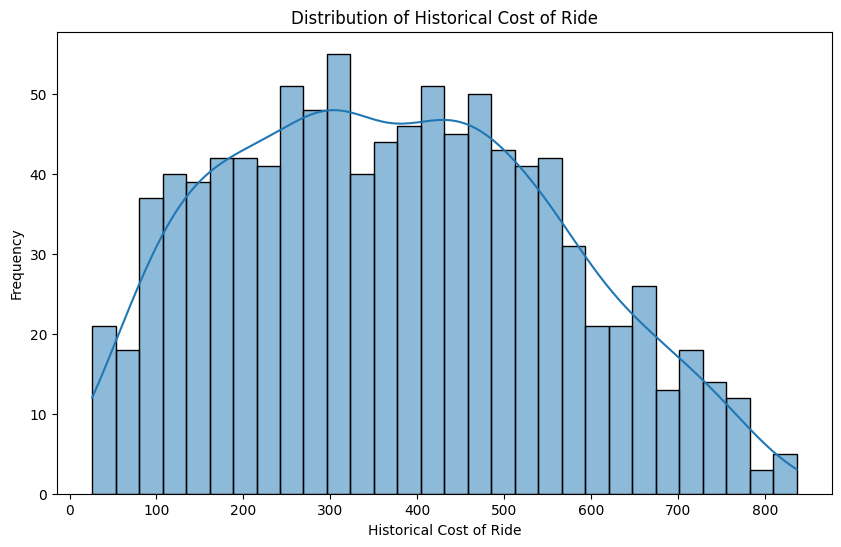

In [12]:
# Distribution of target variable ('Historical_Cost_of_Ride')
plt.figure(figsize=(10,6))
sns.histplot(data['Historical_Cost_of_Ride'], bins=30, kde=True)
plt.title('Distribution of Historical Cost of Ride')
plt.xlabel('Historical Cost of Ride')
plt.ylabel('Frequency')
plt.show()

Normal Distribution of target variable

In [13]:
categorical_cols=data.select_dtypes(include=['object']).columns
numerical_cols=data.select_dtypes(include=['int64','float64']).columns

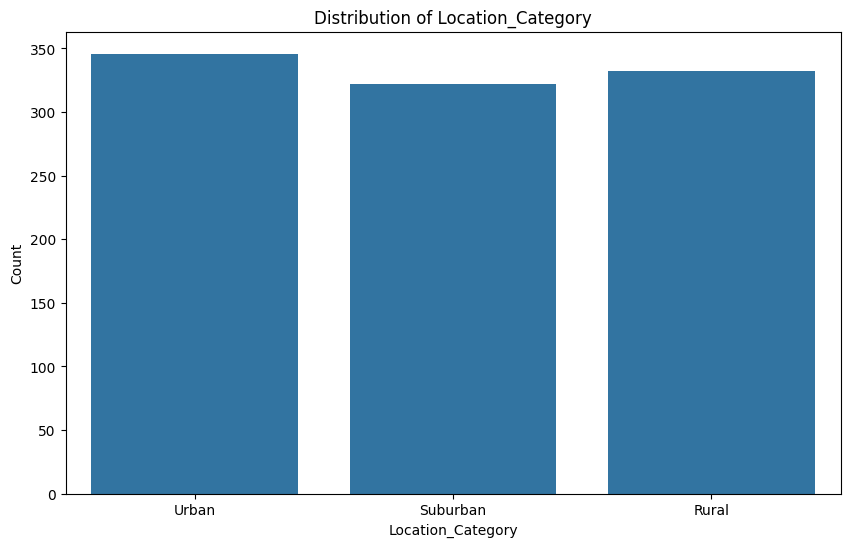

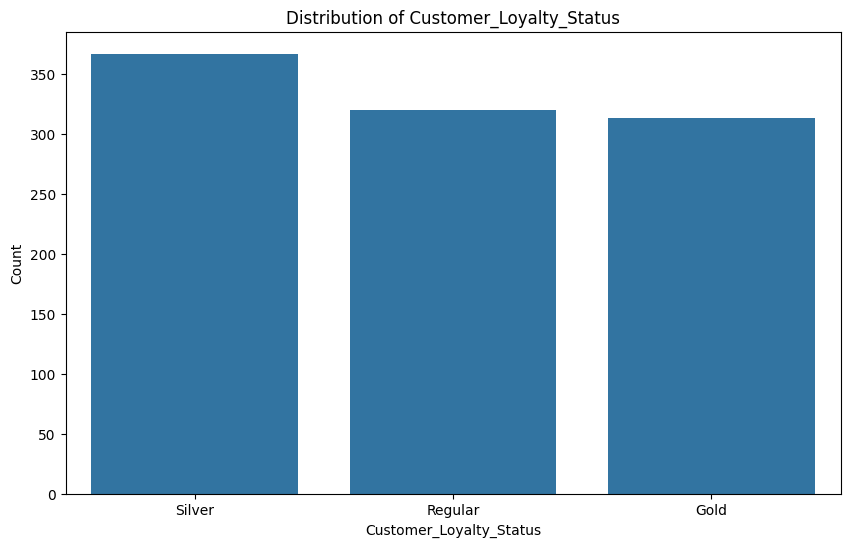

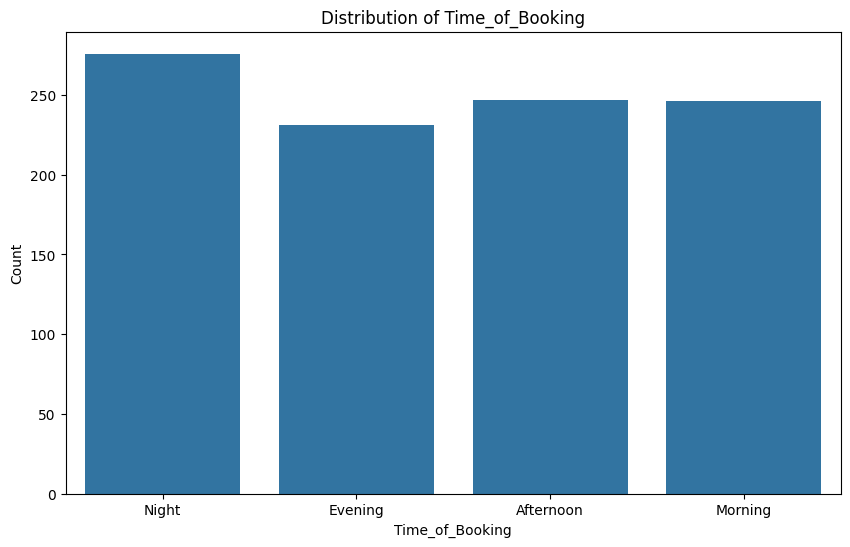

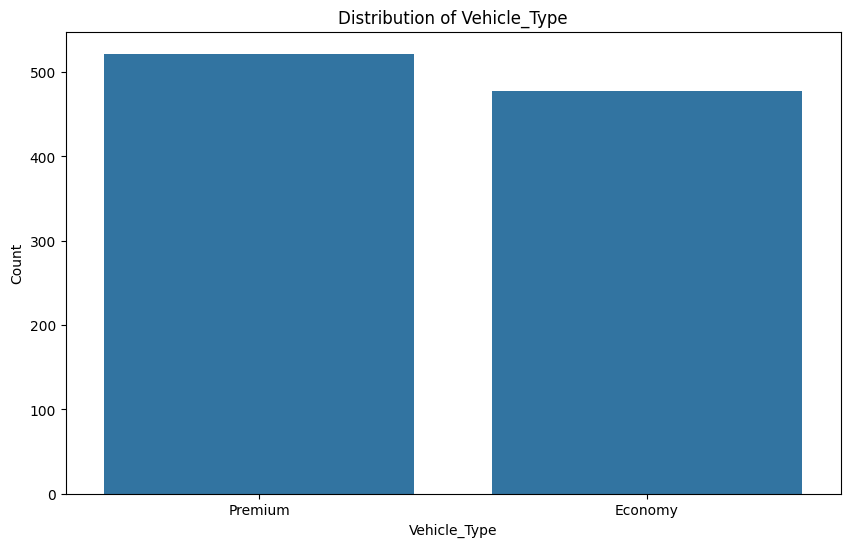

In [14]:
for col in categorical_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

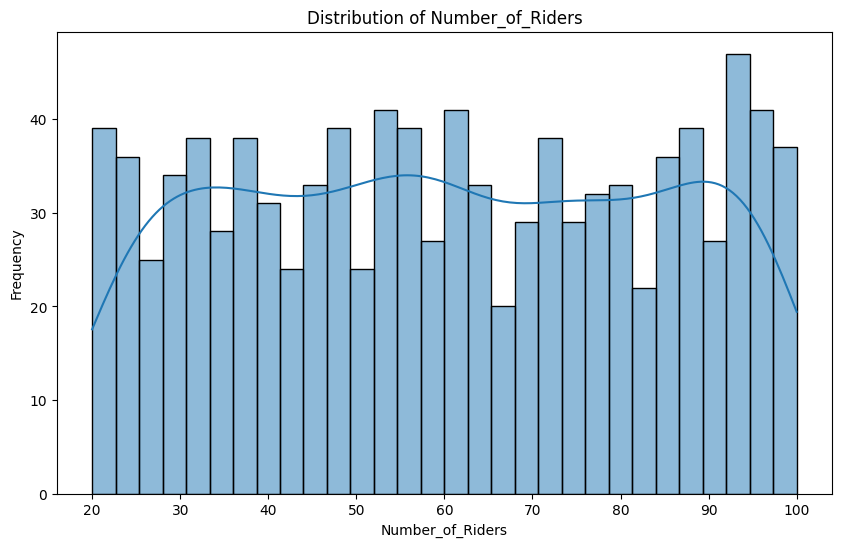

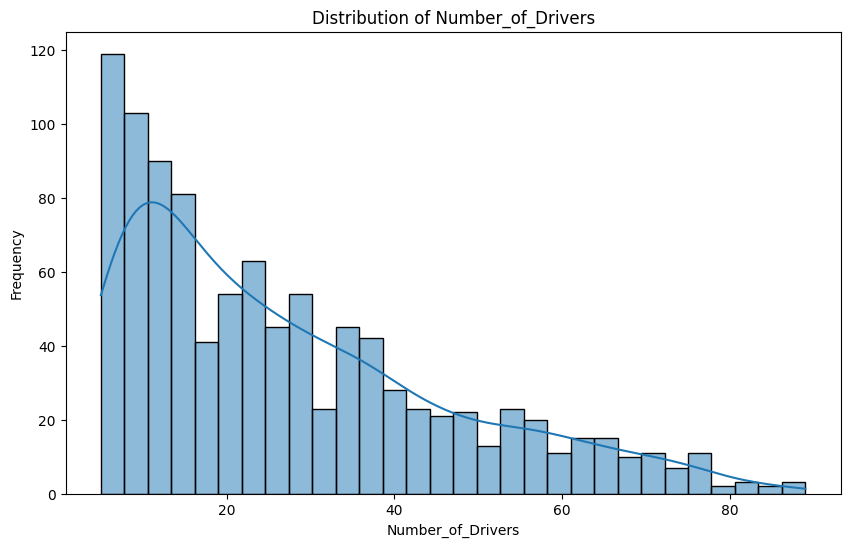

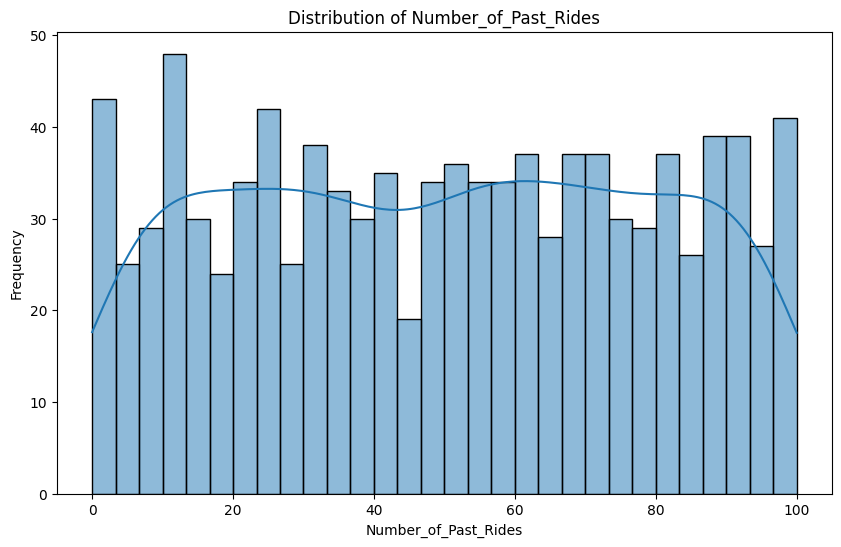

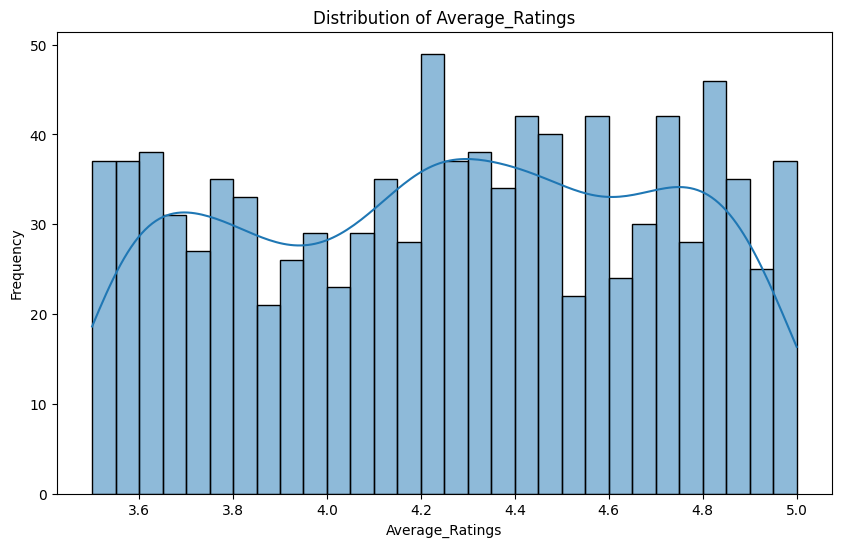

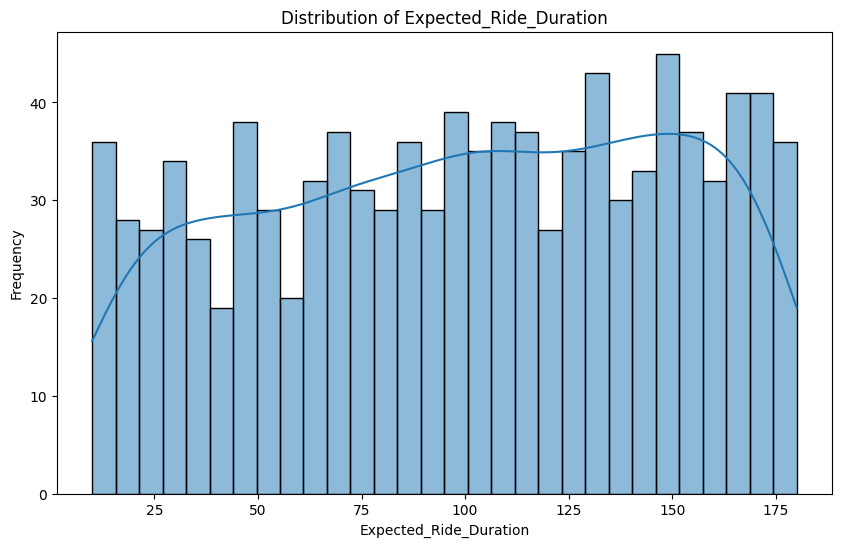

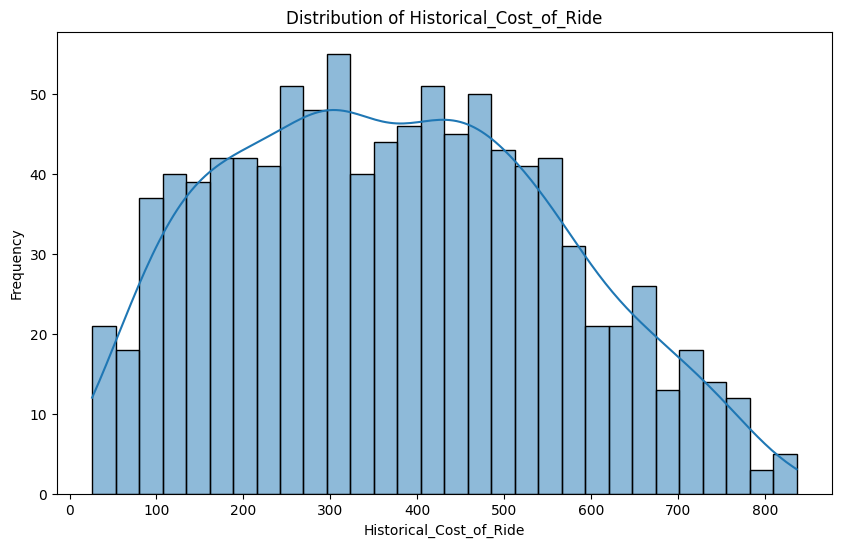

In [15]:
for col in numerical_cols:
    plt.figure(figsize=(10,6))
    sns.histplot(data[col],bins=30,kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

All Numerical columns are normal distribution except (Number of Drivers) column.

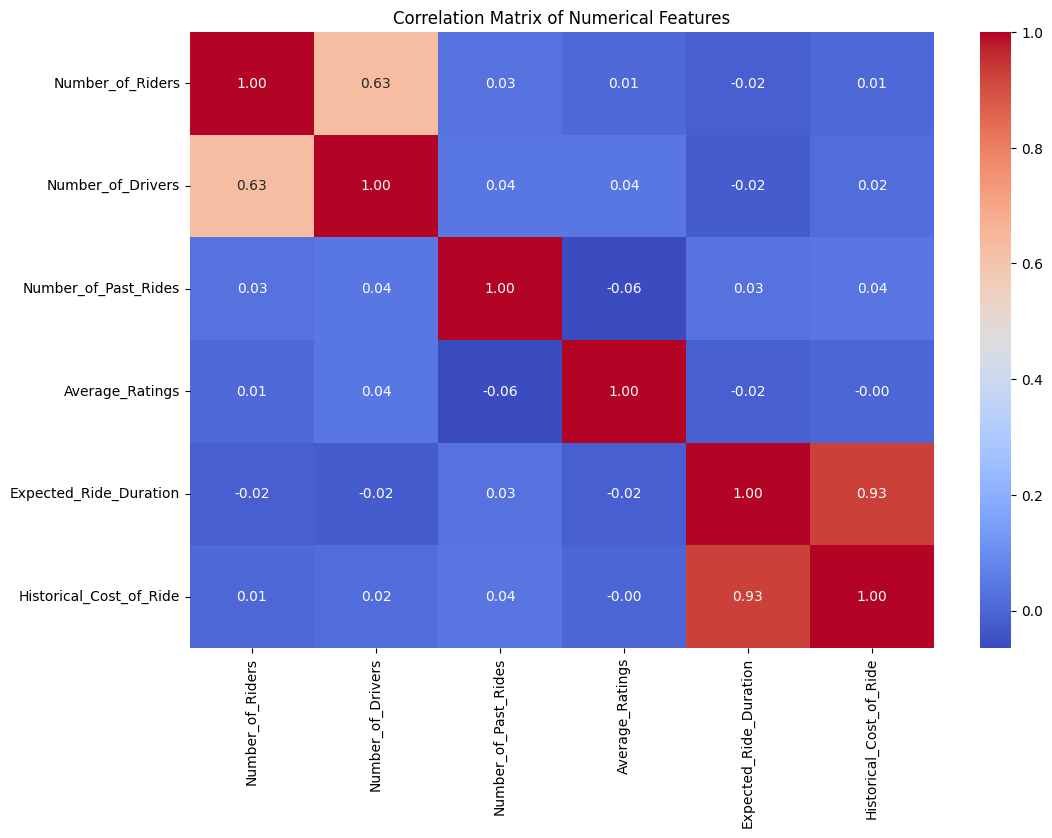

In [16]:
# Correlation between numerical features
plt.figure(figsize=(12,8))
sns.heatmap(data[numerical_cols].corr(),annot=True,fmt=".2f",cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

- Historical_Cost_of_Ride (target variable) has a direct correlation with Number_of_Riders , Number_of_Drivers , Number_of_Past_Rides and strong correlation with Expected_Ride_Duration.
- The most columns have a direct corelation between each other.

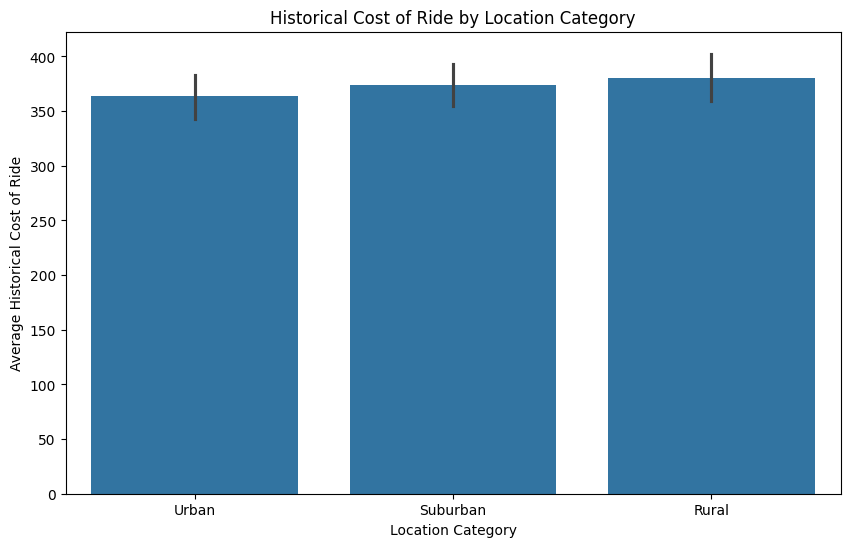

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(data=data,x='Location_Category',y='Historical_Cost_of_Ride')
plt.title('Historical Cost of Ride by Location Category')
plt.xlabel('Location Category')
plt.ylabel('Average Historical Cost of Ride')
plt.show()

The Higher cost of ride is to Rural then Suburban , followed by Urban.

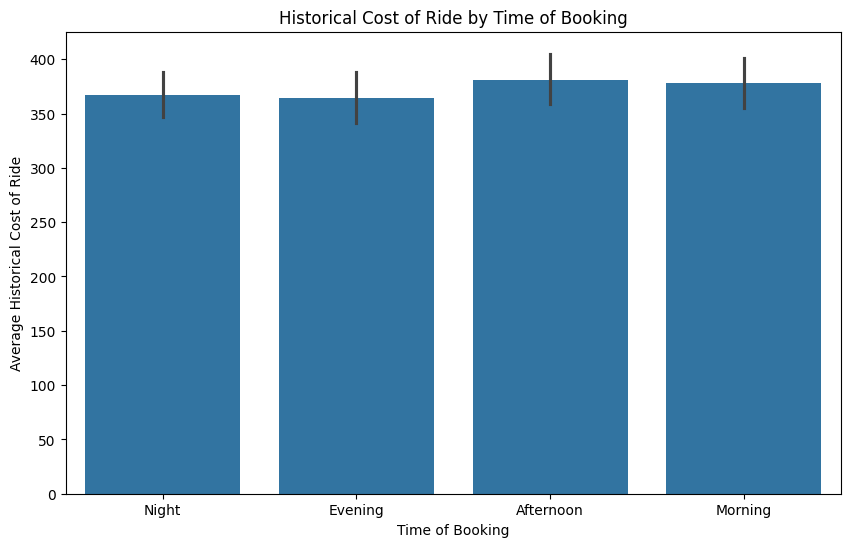

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(data=data,x='Time_of_Booking',y='Historical_Cost_of_Ride')
plt.title('Historical Cost of Ride by Time of Booking')
plt.xlabel('Time of Booking')
plt.ylabel('Average Historical Cost of Ride')
plt.show()

The Higher cost of rides are booking at Afternoon time then Morning followed by Night and Evening

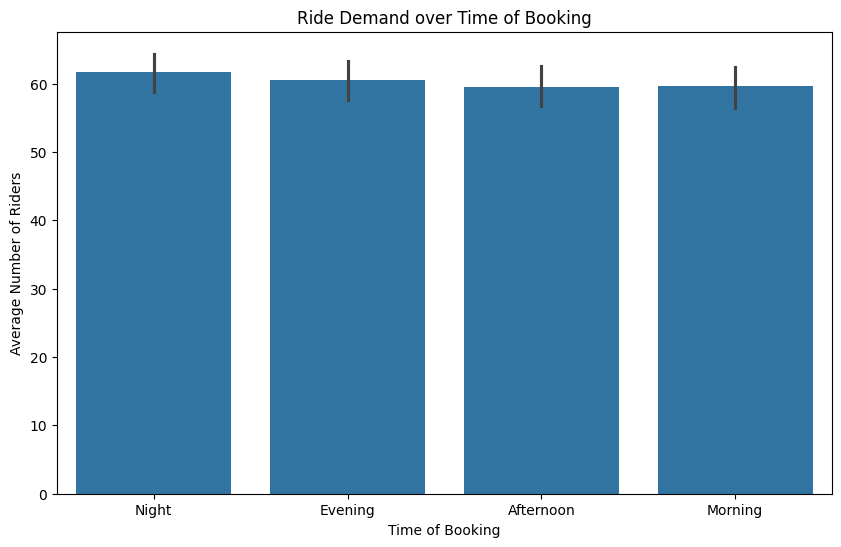

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='Time_of_Booking',y='Number_of_Riders')
plt.title('Ride Demand over Time of Booking')
plt.xlabel('Time of Booking')
plt.ylabel('Average Number of Riders')
plt.show()

The Higher Number of Riders (Demand) booking at Night then Evening , followed by Afternoon and Morning.

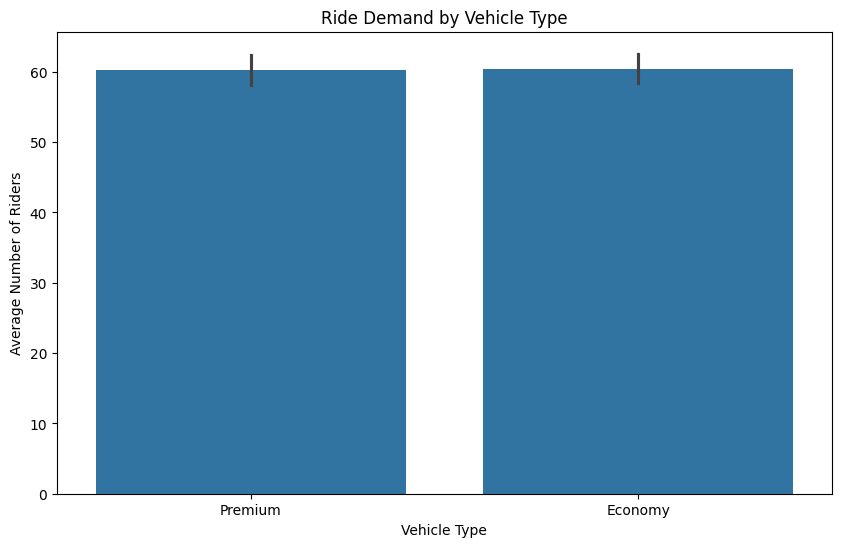

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='Vehicle_Type',y='Number_of_Riders')
plt.title('Ride Demand by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Average Number of Riders')
plt.show()

The same number of riders demand the two types of vehicle.

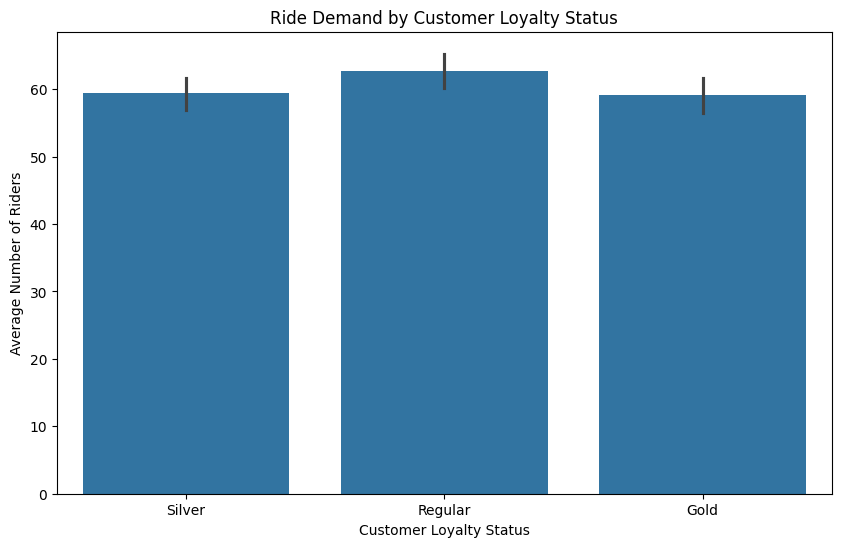

In [21]:
plt.figure(figsize=(10,6))
sns.barplot(data=data,x='Customer_Loyalty_Status',y='Number_of_Riders')
plt.title('Ride Demand by Customer Loyalty Status')
plt.xlabel('Customer Loyalty Status')
plt.ylabel('Average Number of Riders')
plt.show()

The Higher number of riders are Regular status then Silver , followed by Gold.

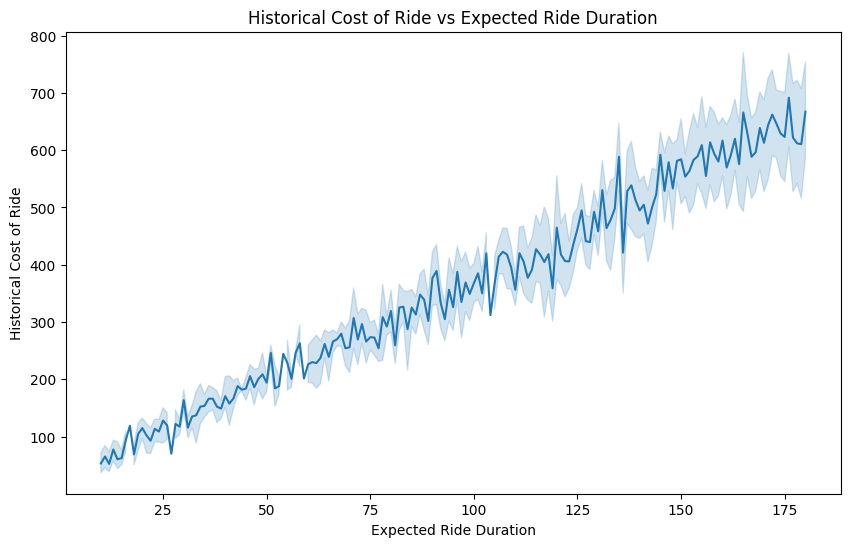

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(data=data,x='Expected_Ride_Duration',y='Historical_Cost_of_Ride')
plt.title('Historical Cost of Ride vs Expected Ride Duration')
plt.xlabel('Expected Ride Duration')
plt.ylabel('Historical Cost of Ride')
plt.show()

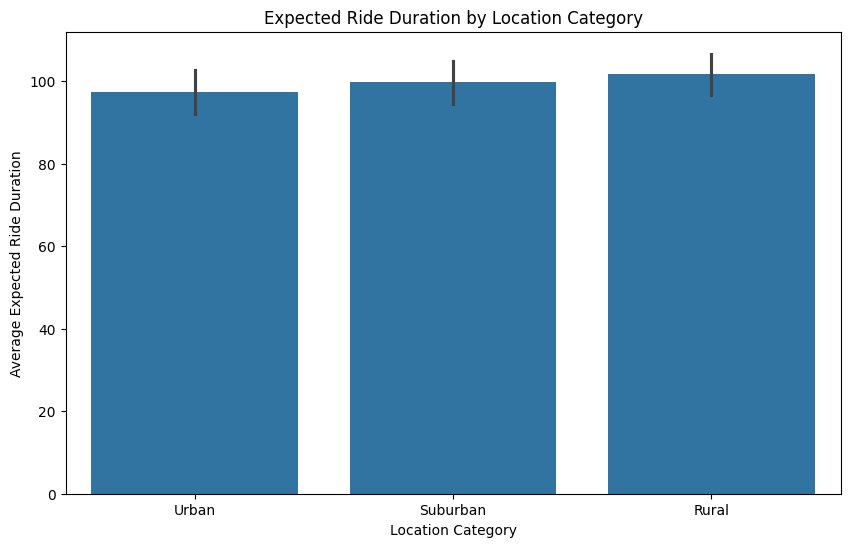

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(data=data,x='Location_Category',y='Expected_Ride_Duration')
plt.title('Expected Ride Duration by Location Category')
plt.xlabel('Location Category')
plt.ylabel('Average Expected Ride Duration')
plt.show()

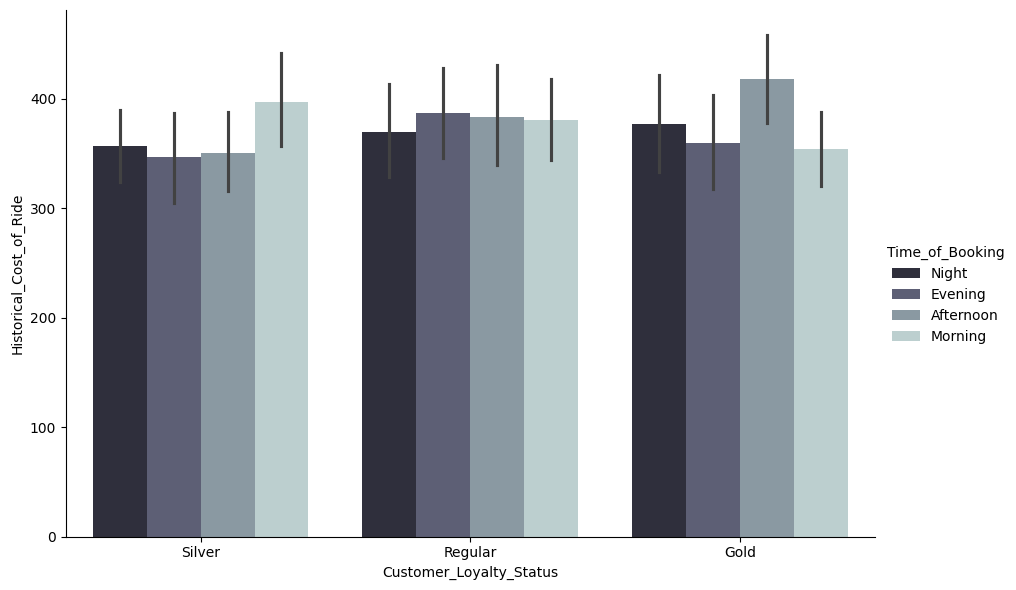

In [24]:
sns.catplot(data=data,x='Customer_Loyalty_Status',y='Historical_Cost_of_Ride',hue='Time_of_Booking',kind='bar',height=6,aspect=1.5,palette='bone')

In [25]:
data.columns

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')

#### Feature Engineering

In [26]:
# # Extract supply demand factor from Number_of_Riders(Demand) and Number_of_Drivers(Supply) 
# data['Supply_Demand_Factor']=data['Number_of_Riders'] / (data['Number_of_Drivers'] + 1)
# data['Demand_Pressure']=data['Number_of_Riders'] - data['Number_of_Drivers']
# data['Drivers_Availability_Ratio']=data['Number_of_Drivers'] / (data['Number_of_Riders'] + 1)
# data.head(10)

In [27]:
np.percentile(data['Number_of_Riders'], [10, 25, 50, 75, 90])

array([27.9, 40. , 60. , 81. , 93. ])

In [28]:
np.percentile(data['Number_of_Drivers'],[10,25,50,75,90])

array([ 7., 11., 22., 38., 56.])

In [29]:
low_demand_percentile=np.percentile(data['Number_of_Riders'],25)
high_demand_percentile=np.percentile(data['Number_of_Riders'],75)

In [30]:
# Calulate Demand Multiplier
data['Demand_Multiplier']=np.where(data['Number_of_Riders']>=high_demand_percentile,1.3,
                                   np.where(data['Number_of_Riders']<=low_demand_percentile,0.85,1.0))

In [31]:
low_supply_percentile=np.percentile(data['Number_of_Drivers'],25)
high_supply_percentile=np.percentile(data['Number_of_Drivers'],75)

In [32]:
# Calulate Supply Multiplier
data['Supply_Multiplier']=np.where(data['Number_of_Drivers']<=low_supply_percentile,1.25,
                                   np.where(data['Number_of_Drivers']>=high_supply_percentile,0.9,1))

In [33]:
# Calculate Adjusted Price
data['Adjusted_Price']=(data['Historical_Cost_of_Ride'] * data['Demand_Multiplier'] * data['Supply_Multiplier'])

In [34]:
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Demand_Multiplier,Supply_Multiplier,Adjusted_Price
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.3,0.9,332.581009
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.0,0.9,156.487277
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.0,1.0,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.3,1.0,611.261601
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.0,1.0,579.681422


#### Modeling

In [35]:
# Mapping Categorical Features
data['Customer_Loyalty_Status']=data['Customer_Loyalty_Status'].map({'Regular':0,'Silver':1,'Gold':2})
data['Time_of_Booking']=data['Time_of_Booking'].map({'Morning':0,'Afternoon':1,'Evening':2,'Night':3})
data['Vehicle_Type']=data['Vehicle_Type'].map({'Economy':0,'Premium':1})

In [36]:
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Demand_Multiplier,Supply_Multiplier,Adjusted_Price
0,90,45,Urban,1,13,4.47,3,1,90,284.257273,1.3,0.9,332.581009
1,58,39,Suburban,1,72,4.06,2,0,43,173.874753,1.0,0.9,156.487277
2,42,31,Rural,1,0,3.99,1,1,76,329.795469,1.0,1.0,329.795469
3,89,28,Rural,0,67,4.31,1,1,134,470.201232,1.3,1.0,611.261601
4,78,22,Rural,0,74,3.77,1,0,149,579.681422,1.0,1.0,579.681422


In [37]:
data.drop(['Demand_Multiplier','Supply_Multiplier'],axis=1,inplace=True)

In [38]:
X=data.drop(['Adjusted_Price'],axis=1)
y=data['Adjusted_Price']

In [39]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [40]:
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')


X train shape: (800, 10)
X test shape: (200, 10)
y train shape: (800,)
y test shape: (200,)


In [41]:
X_train=pd.get_dummies(X_train,columns=['Location_Category'],drop_first=True)
X_test=pd.get_dummies(X_test,columns=['Location_Category'],drop_first=True)

In [42]:
parameters={
    'n_estimators':[100,300,500,700],
    'max_depth':[5,10,15,20,30],
    'learning_rate':[0.01,0.05,0.1,0.2],
    'subsample':[0.7,0.8,1],
    'min_child_weight':[1,3,5],
    'gamma':[0,0.1,0.3],
    'reg_alpha':[0,0.01,0.1],
    'reg_lambda':[1,1.5,2]
}

In [43]:
randomsearch=RandomizedSearchCV(estimator=XGBRegressor(),param_distributions=parameters,n_iter=20,cv=5,random_state=42,n_jobs=-1,verbose=2)

In [44]:
randomsearch.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [5, 10, ...], 'min_child_weight': [1, 3, ...], ...}"
,n_iter,20
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [45]:
best_model=randomsearch.best_estimator_
print(f'Best Hyperparameters: {randomsearch.best_params_}')

Best Hyperparameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 700, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0}


In [46]:
mlflow.set_experiment('Dynamic Pricing Optimization')

c:\Users\speedlink\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///f:/A7med%20els3eed/projects/Dynamic%20Pricing%20Optimisation/mlruns/250639096821541635', creation_time=1770038013822, experiment_id='250639096821541635', last_update_time=1770038013822, lifecycle_stage='active', name='Dynamic Pricing Optimization', tags={}>

In [47]:
mlflow.xgboost.autolog()
model=XGBRegressor(**best_model.get_params())
model.fit(X_train,y_train)

2026/02/03 16:31:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09651b1cefc1411f85f051eab8ec997b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2026/02/03 16:31:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\speedlink\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling 

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [48]:
y_pred=model.predict(X_test)

2026/02/03 16:31:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\speedlink\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [49]:
print(f'R^2 Train Score: {r2_score(y_train,model.predict(X_train))}')
print(f'R^2 Test Score: {r2_score(y_test,y_pred)}')

2026/02/03 16:31:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\speedlink\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


R^2 Train Score: 0.999999999595271
R^2 Test Score: 0.9938543267054692


In [50]:
print(f'Mean Squared Error: {mean_squared_error(y_test,y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test,y_pred)}')

Mean Squared Error: 288.2259508251765
Mean Absolute Error: 10.150562960416174


#### Model Deployment

In [51]:
import joblib
joblib.dump(model,open('xgboost_dynamic_pricing_model.pkl','wb'))

In [52]:
joblib.dump(X_train.columns.tolist(),'model_features.pkl')

['model_features.pkl']

In [ ]:
{
	"features":{
        "Number_of_Riders":90,
        "Number_of_Drivers":45,
        "Location_Category":"Urban",
        "Customer_Loyalty_Status":"Silver",
        "Number_of_Past_Rides":13,
        "Average_Ratings":4.47,
        "Time_of_Booking":"Night",
        "Vehicle_Type":"Premium",
        "Expected_Ride_Duration":90,
        "Historical_Cost_of_Ride":284.257273
    }
}
90	45	Urban	Silver	13	4.47	Night	Premium	90	284.257273